In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import json
import re
import subprocess
import zipfile
from collections import Counter
import graphviz
from collections import defaultdict
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.colors import Normalize
from matplotlib import cm

In [2]:
with zipfile.ZipFile('server_log.zip', 'r') as z:
    with z.open('rows.csv') as csv_file: 
        df = pd.read_csv(csv_file)

In [3]:
#Q1 What's the total size in bytes of the files requested?
# subprocess.check_output("cd ~/; cd labs-and-projects/mp6/; unzip server_log.zip", shell = True)
# df = pd.read_csv("rows.csv")
# sum(df['size'])
int(sum(df['size']))

24801002666

In [4]:
#Q2 How many filings have been accessed by the 10 IPs with the most accesses?
ip = df['ip'].value_counts()[0:10]
ip_dict = ip.to_dict()
ip_dict

{'54.152.17.ccg': 12562,
 '183.195.251.hah': 6524,
 '52.45.218.ihf': 5562,
 '68.180.231.abf': 5493,
 '204.212.175.bch': 4708,
 '103.238.106.gif': 4428,
 '208.77.215.jeh': 3903,
 '208.77.214.jeh': 3806,
 '217.174.255.dgd': 3551,
 '82.13.163.caf': 3527}

In [5]:
#Q3 What fraction of the requests had errors?
requests = df['code']
requests_error = requests[requests >= 400]
fraction_errors = len(requests_error)/len(requests)
fraction_errors

0.03466852724527611

In [6]:
#Q4 What is the second most frequently accessed file?
sampledf = df
sampledf['cik'] = sampledf['cik'].astype(int)
file_counts = sampledf.groupby(['cik', 'accession', 'extention']).size().reset_index(name='counts')
sorted_file_counts = file_counts.sort_values(by='counts', ascending=False)
second = sorted_file_counts.iloc[1]
file = f"{second['cik']}/{second['accession']}/{second['extention']}"
file

'1584509/0001584509-16-000514/armk-20160930_def.xml'

In [7]:
import edgar_utils

In [8]:
#Q5 Which region accesses resources most heavily in server_log.zip?
# iptoint['ip'] = df['ip'].astype(int)
# region['region'] = df['ip'].apply(edgar_utils.lookup_region)
cleanips = {'region': []}
ips = df['ip']
for ip in ips:
    sample = edgar_utils.lookup_region(ip)
    cleanips['region'].append(sample)
    
cleanipstodf = pd.DataFrame(cleanips)
counts = cleanipstodf['region'].value_counts()
counts.keys()[0]

'United States of America'

In [9]:
#Q6 What fraction of IPs in each region are high-volume users?
sampledf['region'] = sampledf['ip'].apply(edgar_utils.lookup_region)
high_traffic = sampledf.groupby(['ip', 'region']).size().reset_index(name='counts')
high_traffic_sorted = high_traffic.sort_values(by='counts', ascending=False)
high_traffic_300 = high_traffic_sorted[high_traffic_sorted['counts'] > 300]
sorted_traffic = high_traffic_sorted['region'].value_counts()
sorted_traffic_300 = high_traffic_300['region'].value_counts()
fraction_ip = sorted_traffic_300/sorted_traffic
fraction_ip.fillna(0, inplace=True) 
fraction_ip.to_dict()

{'-': 0.0,
 'Algeria': 0.0,
 'Angola': 0.0,
 'Armenia': 0.0,
 'Australia': 0.07692307692307693,
 'Austria': 0.0,
 'Bangladesh': 0.0,
 'Brazil': 0.0,
 'Bulgaria': 0.3333333333333333,
 'Canada': 0.05357142857142857,
 'China': 0.016018306636155607,
 'Croatia': 0.0,
 'Cyprus': 0.0,
 'Czechia': 0.3333333333333333,
 'Denmark': 0.0,
 'Egypt': 0.0,
 'Estonia': 0.0,
 'Finland': 0.0,
 'France': 0.0036900369003690036,
 'Germany': 0.047619047619047616,
 'Greece': 0.0,
 'Honduras': 0.0,
 'Hong Kong': 0.037037037037037035,
 'Hungary': 0.0,
 'India': 0.08823529411764706,
 'Indonesia': 0.0,
 'Iraq': 0.0,
 'Ireland': 0.625,
 'Israel': 0.0,
 'Italy': 0.0,
 'Japan': 0.0,
 'Jersey': 0.0,
 'Jordan': 0.0,
 'Korea (Republic of)': 0.2,
 'Latvia': 0.0,
 'Lebanon': 0.0,
 'Liberia': 0.0,
 'Luxembourg': 0.0,
 'Malaysia': 0.0,
 'Mexico': 0.0,
 'Mongolia': 0.0,
 'Morocco': 0.0,
 'Netherlands': 0.0,
 'Nigeria': 0.0,
 'North Macedonia': 0.0,
 'Pakistan': 0.0,
 'Philippines': 0.0,
 'Poland': 0.0,
 'Portugal': 0.0,
 'R

In [10]:
#Q7 What dates appear in the 886982/0000769993-16-001958/-index.htm file of docs.zip?
with zipfile.ZipFile('docs.zip', 'r') as z:
    index_file = '886982/0000769993-16-001958/-index.htm'
    with z.open(index_file) as f:
        html = f.read().decode('utf-8')

filing = edgar_utils.Filing(html)
filing.dates

['2016-12-30', '2016-12-30', '2016-12-20']

In [11]:
#filings dictionary
filings_dict = {}
with zipfile.ZipFile('docs.zip', 'r') as z:
    for file in z.namelist():
        if file.endswith(('.htm', '.html')):
            with z.open(file) as f:
                html_content = f.read().decode('utf-8', errors='ignore') 
                filing = edgar_utils.Filing(html_content) 
                filings_dict[file] = filing  

In [12]:
#Q8 What is the distribution of states for the filings in docs.zip
counter = Counter()
for filing in filings_dict.values():
    state = filing.state()  
    if state:
        counter[state] += 1 
    else:
        counter[None] += 1  

state_distribution = dict(sorted(counter.items(), key=lambda x: (x[0] is None, x[0])))
state_distribution

{'AL': 1,
 'AR': 1,
 'AZ': 5,
 'CA': 92,
 'CO': 25,
 'CT': 14,
 'DC': 1,
 'DE': 9,
 'FL': 21,
 'GA': 9,
 'IA': 6,
 'ID': 1,
 'IL': 25,
 'IN': 5,
 'KS': 5,
 'KY': 2,
 'LA': 2,
 'MA': 30,
 'MD': 13,
 'ME': 1,
 'MI': 11,
 'MN': 15,
 'MO': 4,
 'MS': 1,
 'NC': 9,
 'NE': 2,
 'NJ': 23,
 'NM': 1,
 'NV': 6,
 'NY': 83,
 'OH': 10,
 'OK': 7,
 'OR': 2,
 'PA': 25,
 'SD': 1,
 'TN': 4,
 'TX': 67,
 'UT': 5,
 'VA': 15,
 'VT': 1,
 'WA': 3,
 'WI': 9,
 'WV': 2,
 None: 56}

In [13]:
#Q9 What is the distribution for the ten most common addresses for the filings in docs.zip?
counter = Counter()

with zipfile.ZipFile('docs.zip', 'r') as z:
    for file in z.namelist():
        if file.endswith('.htm'):
            with z.open(file) as f:
                html = f.read().decode('utf-8')
                filing = edgar_utils.Filing(html)
                counter.update(filing.addresses)

top_addresses = counter.most_common(10)
top_addresses_dict = dict(top_addresses)
nospace = {re.sub(r'\s{2,}', '\n', k): v for k, v in top_addresses_dict.items()}
nospace

{'2000 AVENUE OF THE STARS, 12TH FLOOR\nLOS ANGELES CA 90067': 134,
 '2000 AVENUE OF THE STARS, 12TH FLOOR\nLOS ANGELES CA 90067\n3102014100': 113,
 '3 LANDMARK SQUARE\nSUITE 500\nSTAMFORD CT 06901\n2033564400': 60,
 'C/O KKR ASSET MANAGEMENT LLC\n555 CALIFORNIA STREET, 50TH FLOOR\nSAN FRANCISCO CA 94104': 36,
 'C/O ARES MANAGEMENT LLC\n2000 AVENUE OF THE STARS, 12TH FLOOR\nLOS ANGELES CA 90067': 35,
 '4740 AGAR DRIVE\nRICHMOND A1 V7B 1A3': 25,
 'CENTRALIS S.A., 8-10 AVENUE DE LA GARE\nLUXEMBOURG N4 L-1610': 25,
 'CENTRALIS S.A., 8-10 AVENUE DE LA GARE\nLUXEMBOURG N4 L-1610\n352-26-186-1': 25,
 '3 LANDMARK SQUARE\nSUITE 500\nSTAMFORD CT 06901': 24,
 '801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102': 22}

In [14]:
#Q10 What is the distribution of requests across industries?
def get_sic_distribution(df, filings_dict):
    df['cik'] = df['cik'].astype(int)
    sic_distribution = defaultdict(int)
    for _, row in df.iterrows():
        path = f"{row['cik']}/{row['accession']}/{row['extention']}"
        if path in filings_dict:
            filing_obj = filings_dict[path]
            sic = filing_obj.sic
            if sic is not None:
                sic_distribution[sic] += 1
    result = dict(sic_distribution)
    result_sorted = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))
    return result_sorted

sic_distribution = get_sic_distribution(df, filings_dict)
sic_distribution

{2834: 984,
 1389: 656,
 1311: 550,
 2836: 429,
 6022: 379,
 1000: 273,
 6211: 237,
 7371: 229,
 2860: 226,
 6021: 204,
 6282: 171,
 2510: 171,
 3825: 164,
 4841: 108,
 5621: 99,
 7200: 94,
 7374: 94,
 6331: 91,
 6798: 90,
 5311: 90,
 3842: 87,
 6221: 85,
 6029: 83,
 3272: 81,
 3829: 73,
 4931: 70,
 3510: 66,
 7830: 62,
 3826: 56,
 3695: 55,
 3620: 50,
 7373: 48,
 6799: 46,
 4412: 43,
 4512: 42,
 7340: 40,
 7370: 39,
 900: 39,
 6513: 38,
 3621: 38,
 5172: 36,
 5900: 35,
 4213: 35,
 3990: 34,
 5122: 34,
 5944: 33,
 2070: 33,
 8090: 32,
 1700: 31,
 3312: 31,
 1381: 31,
 4922: 31,
 6324: 30,
 8742: 27,
 7389: 26,
 8731: 25,
 7812: 25,
 3590: 24,
 4955: 23,
 3663: 23,
 4522: 22,
 6321: 21,
 3559: 20,
 5812: 19,
 6792: 19,
 6189: 18,
 7372: 16,
 3841: 14,
 6199: 11,
 1731: 11,
 4911: 8,
 4833: 7,
 6035: 7,
 3571: 6,
 2430: 6,
 3679: 5,
 3674: 5,
 4813: 4,
 3678: 4,
 4812: 4,
 1531: 4,
 5500: 4,
 6411: 3,
 1400: 3,
 2800: 3,
 3420: 3,
 8062: 3,
 3576: 3,
 2870: 2,
 1040: 2,
 8711: 2,
 3669: 

In [15]:
#Q11 How many requests were made in each hour?
def requests_per_hour(df):
    df['time'] = pd.to_datetime(df['time'], format="%H:%M:%S", errors='coerce')
    df['hour'] = df['time'].dt.hour
    hour_counts = df['hour'].value_counts()
    request_distribution = {hour: count for hour, count in hour_counts.items()}
    requests = {hour: request_distribution.get(hour, 0) for hour in range(24)}
    return requests

total_requests = requests_per_hour(df)
total_requests

{0: 8305,
 1: 8242,
 2: 8550,
 3: 8850,
 4: 8343,
 5: 9783,
 6: 7761,
 7: 8213,
 8: 8292,
 9: 11033,
 10: 6377,
 11: 6435,
 12: 6155,
 13: 6006,
 14: 6654,
 15: 6512,
 16: 5680,
 17: 6487,
 18: 6356,
 19: 6211,
 20: 6066,
 21: 6164,
 22: 6098,
 23: 6283}

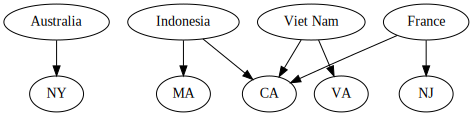

In [16]:
#Q12 What is the geographic overlap in interest between Australia, France, Indonesia, and Viet Nam?
sampledf['cikaccex'] = sampledf['cik'].astype(int).astype(str)+"/"+sampledf['accession'].astype(str)+"/"+sampledf['extention'].astype(str)

dot = graphviz.Digraph(comment='geographic overlap')

countries = ["Australia", "France", "Indonesia", "Viet Nam"]
states = []
region_df = {}
regions = sampledf['region']
for filing in filings_dict.values():
    state = filing.state()  
    states.append(state)

for i in countries:  
    region_df[i] = set()
    

for i in sampledf.itertuples():
    places = i.region

    if places in region_df:
        if i.cikaccex in filings_dict:
            state = filings_dict[i.cikaccex].state()
            region_df[places].add(state)
                   
for country in countries:
    for state in region_df[country]:
        dot.edge(country, state)

dot

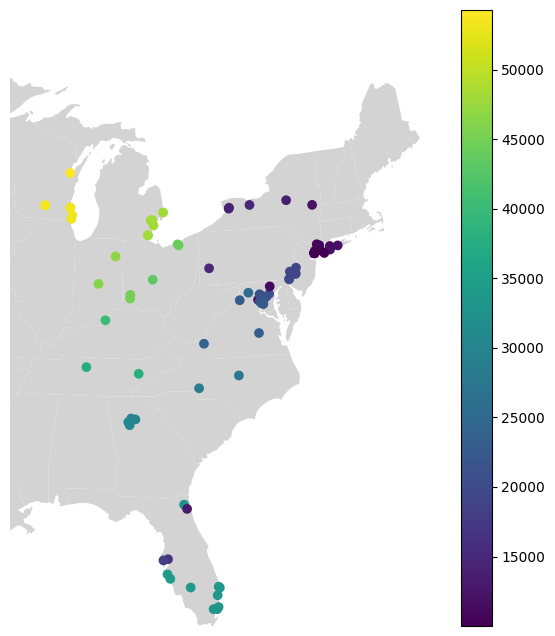

In [17]:
#Q13 Geographic plotting of postal code
west = -90
east = -65
north = 50
south = 25

geojson = gpd.read_file("locations.geojson")
background = gpd.read_file("shapes/cb_2018_us_state_20m.shp")

def extract_postal_code(address):
    match = re.search(r'\b(\d{5})(?:-\d{4})?\b', address)
    return int(match.group(1)) if match else None

geojson['postal_code'] = geojson['address'].apply(extract_postal_code)

geojson = geojson[(geojson['postal_code'] >= 10000) & (geojson['postal_code'] <= 60000)]
geojson = geojson[
    (geojson.geometry.x >= west) & 
    (geojson.geometry.x <= east) & 
    (geojson.geometry.y >= south) & 
    (geojson.geometry.y <= north)
]

if not isinstance(geojson, gpd.GeoDataFrame):
    geojson = gpd.GeoDataFrame(geojson, geometry=gpd.points_from_xy(geojson.lon, geojson.lat))

background = background.to_crs(epsg=2022)
geojson = geojson.to_crs(epsg=2022)

bounds = gpd.GeoDataFrame(
    geometry=[Point(west, south), Point(east, north)],
    crs="EPSG:4326"
).to_crs(epsg=2022).total_bounds

fig, ax = plt.subplots(figsize=(10, 8))
background.plot(ax=ax, color="lightgray")
geojson.plot(ax=ax, column='postal_code', cmap="viridis", legend=True)
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.axis("off")
plt.show()
